<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [4]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [3]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [2]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [5]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [6]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [7]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.07 seconds


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

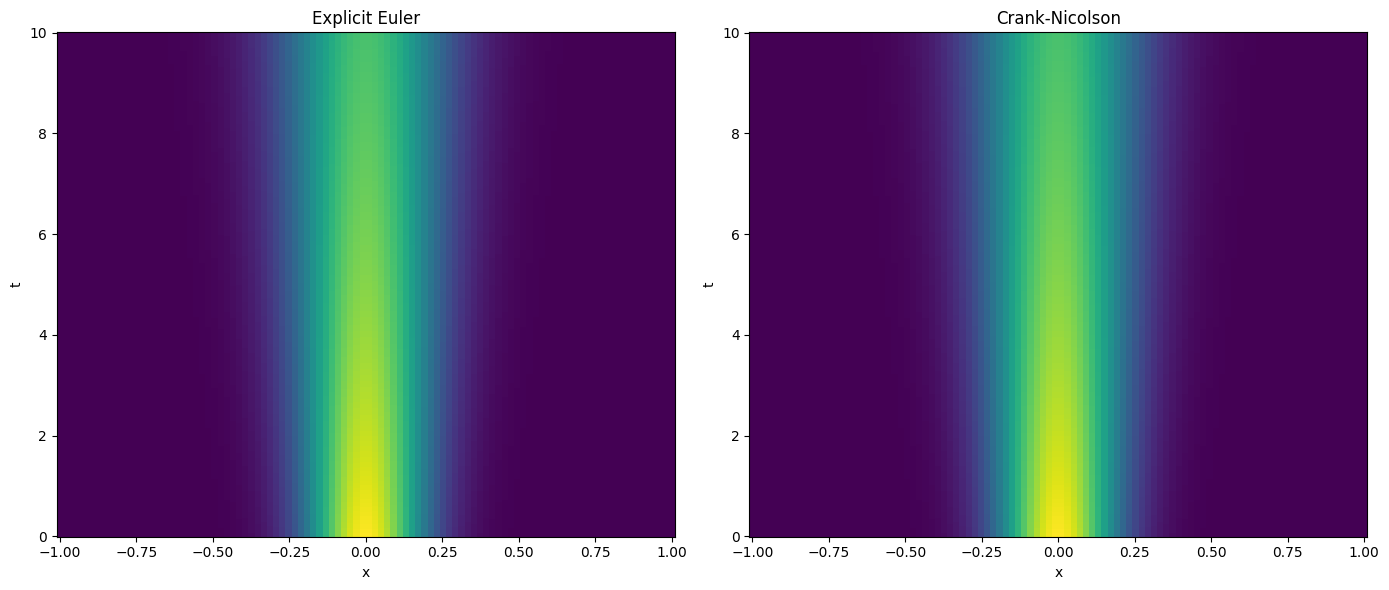

In [8]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing Nx (decreasing the grid spacing, $\Delta x$) and/or increase the diffusivity, $\kappa$, and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

INSERT COMMENTS HERE

Here below, I have considered a **set of kappa values** for each iteration while the rest of the **parameters remain constant**.
It is worthy to note that the Explicit Euler method becomes unstable as the kappa value increases while Crank-Nicolson method remains fairly stable for higher kappa values.

Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.06 seconds


<ipython-input-3-9171c2f9dd57>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


Crank-Nicolson method took 0.06 seconds


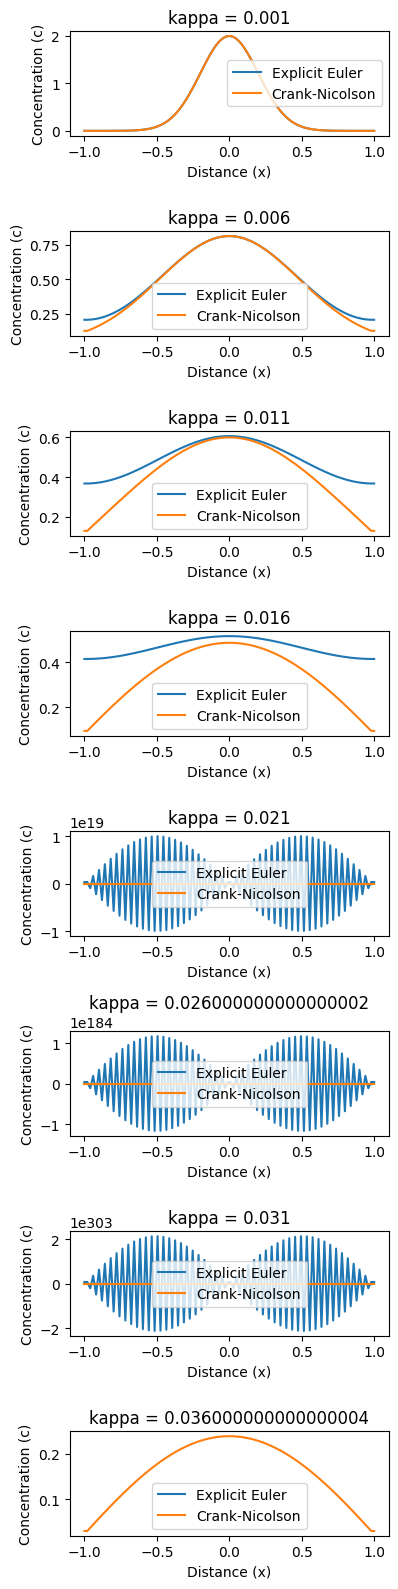

In [9]:
# Defining parameters
kappa = [0.001 + i * 0.005 for i in range(8)]  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

fig, axes = plt.subplots(len(kappa), 1, figsize=(4, 2 * len(kappa)))

for i, kappa in enumerate(kappa):
    # Run the simulations
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)

    # Extract concentration profiles at the final time
    EE_profile = c_EE[:, -1]
    CN_profile = c_CN[:, -1]

    # Plot on the corresponding subplot
    ax = axes[i]
    ax.plot(x, EE_profile, label='Explicit Euler')
    ax.plot(x, CN_profile, label='Crank-Nicolson')
    ax.set_xlabel('Distance (x)')
    ax.set_ylabel('Concentration (c)')
    ax.set_title(f'kappa = {kappa}')
    ax.legend()

plt.tight_layout()
plt.show()






Next I have have kept the Kappa value fixed while decreasing the grid size ($\Delta x$) to investigate the model for finer grid.
It can be seen that both Explicit euler method and Crank-Nicolson method is stable for finer mesh.

Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.11 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.13 seconds


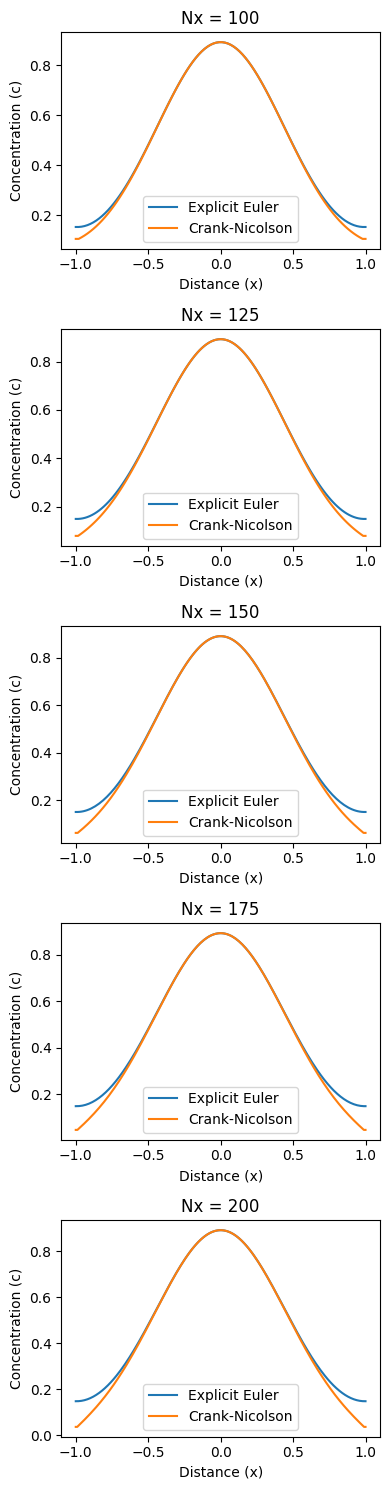

In [10]:
# Defining parameters
kappa = 0.005  # Fixed kappa value
Nx_values = [100 + i * 25 for i in range(5)]  # Varying Nx

# Timestepping parameters
t_start = 0
t_end = 10
Nt = 1000

# Size of the physical domain
x_start = -1
x_end = 1

t = np.linspace(t_start, t_end, Nt)

# Create a figure with subplots for each Nx value
fig, axes = plt.subplots(len(Nx_values), 1, figsize=(4, 3 * len(Nx_values)))

# Iterate through Nx values
for i, Nx in enumerate(Nx_values):
    x = np.linspace(x_start, x_end, Nx)  # Update x for current Nx

    # Run the simulations
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)

    # Extract concentration profiles at the final time
    EE_profile = c_EE[:, -1]
    CN_profile = c_CN[:, -1]

    # Plot on the corresponding subplot
    ax = axes[i]
    ax.plot(x, EE_profile, label='Explicit Euler')
    ax.plot(x, CN_profile, label='Crank-Nicolson')
    ax.set_xlabel('Distance (x)')
    ax.set_ylabel('Concentration (c)')
    ax.set_title(f'Nx = {Nx}')
    ax.legend()

plt.tight_layout()
plt.show()

Below is for fixed kappa and fixed grid but for decreasing computational time-step. Both methods are stable for decreased time-step although it takes longer to carry out the computation.

Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.08 seconds
Explicit Euler method took 0.13 seconds
Crank-Nicolson method took 0.11 seconds
Explicit Euler method took 0.17 seconds
Crank-Nicolson method took 0.11 seconds
Explicit Euler method took 0.17 seconds
Crank-Nicolson method took 0.13 seconds


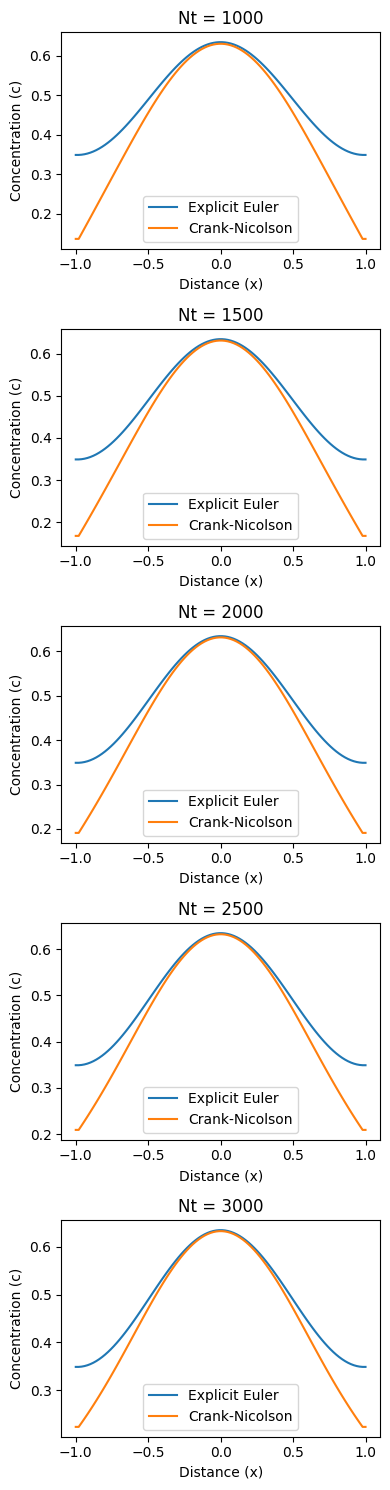

In [11]:
# Defining parameters
kappa = 0.01  # Fixed kappa value
Nx = 100  # Fixed Nx value
Nt_values = [1000 + i * 500 for i in range(5)]  # Varying Nt

# Size of the physical domain
x_start = -1
x_end = 1

x = np.linspace(x_start, x_end, Nx)

# Create a figure with subplots for each Nt value
fig, axes = plt.subplots(len(Nt_values), 1, figsize=(4, 3 * len(Nt_values)))

# Iterate through Nt values
for i, Nt in enumerate(Nt_values):
    t_start = 0
    t_end = 10
    t = np.linspace(t_start, t_end, Nt)  # Update t for current Nt

    # Run the simulations
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)

    # Extract concentration profiles at the final time
    EE_profile = c_EE[:, -1]
    CN_profile = c_CN[:, -1]

    # Plot on the corresponding subplot
    ax = axes[i]
    ax.plot(x, EE_profile, label='Explicit Euler')
    ax.plot(x, CN_profile, label='Crank-Nicolson')
    ax.set_xlabel('Distance (x)')
    ax.set_ylabel('Concentration (c)')
    ax.set_title(f'Nt = {Nt}')
    ax.legend()

plt.tight_layout()
plt.show()

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.06 seconds


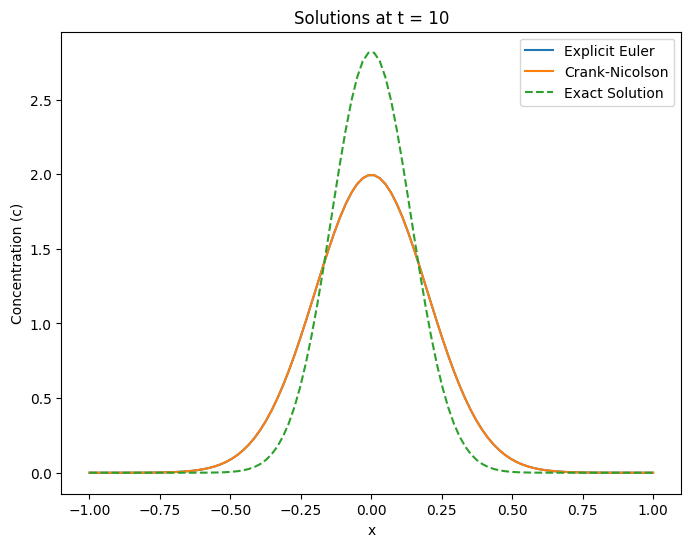

In [12]:
# Add code to plot exact and numerical solutions

# Defining parameters
kappa = 0.001  # diffusivity
t_end = 10  # final time
Nx = 100  # number of grid points in x
Nt = 1000  # number of time steps

# Size of the physical domain
x_start = -1
x_end = 1

# Create x and t vectors
x = np.linspace(x_start, x_end, Nx)
t = np.linspace(0, t_end, Nt)

# Run the simulations
c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)

# Calculate the exact solution at the final time
def exact_solution(x, t, kappa):
    return (4 * np.pi * kappa * t)**(-0.5) * np.exp(-x**2 / (4 * kappa * t))

c_exact = exact_solution(x, t_end, kappa)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(x, c_EE[:, -1], label='Explicit Euler')
plt.plot(x, c_CN[:, -1], label='Crank-Nicolson')
plt.plot(x, c_exact, label='Exact Solution', linestyle='--')
plt.xlabel('x')
plt.ylabel('Concentration (c)')
plt.title(f'Solutions at t = {t_end}')
plt.legend()
plt.show()

Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.13 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.48 seconds
Explicit Euler method took 0.11 seconds


<ipython-input-3-9171c2f9dd57>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


Crank-Nicolson method took 1.93 seconds


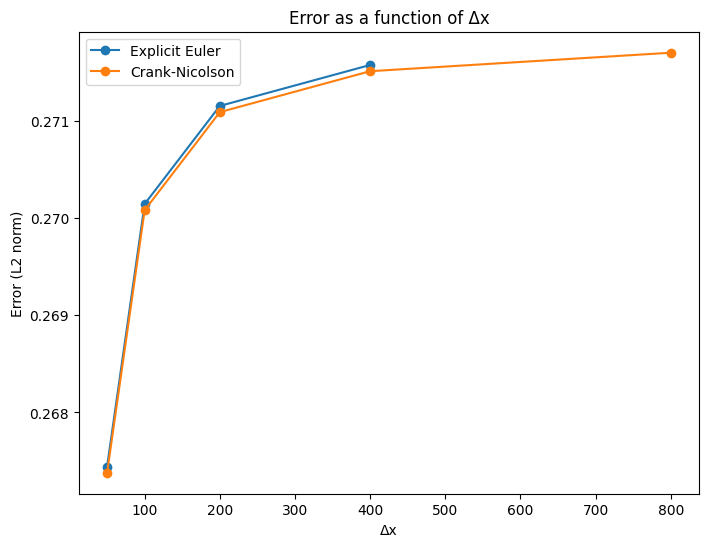

Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.08 seconds


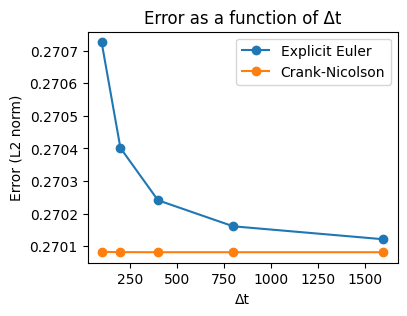

In [13]:
# Defining parameters
kappa = 0.001  # diffusivity
t_end = 10  # final time

# --- Error as a function of Δx ---

# Varying Nx (which changes Δx)
Nx_values = [50, 100, 200, 400, 800]
Nt = 1000  # Fixed Nt

errors_EE_dx = []
errors_CN_dx = []

for Nx in Nx_values:
    x_start = -1
    x_end = 1
    x = np.linspace(x_start, x_end, Nx)
    dx = (x_end - x_start) / (Nx - 1)  # Calculate Δx
    t = np.linspace(0, t_end, Nt)

    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)
    c_exact = exact_solution(x, t_end, kappa)

    # Calculate error using L2 norm (example)
    error_EE = np.sqrt(np.sum((c_EE[:, -1] - c_exact)**2) / Nx)
    error_CN = np.sqrt(np.sum((c_CN[:, -1] - c_exact)**2) / Nx)

    errors_EE_dx.append(error_EE)
    errors_CN_dx.append(error_CN)

# Plot error vs. Δx
plt.figure(figsize=(8, 6))
plt.plot(Nx_values, errors_EE_dx, label='Explicit Euler', marker='o')
plt.plot(Nx_values, errors_CN_dx, label='Crank-Nicolson', marker='o')
plt.xlabel('Δx')
plt.ylabel('Error (L2 norm)')
plt.title('Error as a function of Δx')
plt.legend()
plt.show()


# --- Error as a function of Δt ---

# Varying Nt (which changes Δt)
Nt_values = [100, 200, 400, 800, 1600]
Nx = 100  # Fixed Nx

errors_EE_dt = []
errors_CN_dt = []

for Nt in Nt_values:
    x_start = -1
    x_end = 1
    x = np.linspace(x_start, x_end, Nx)
    t = np.linspace(0, t_end, Nt)
    dt = (t_end - 0) / (Nt - 1)  # Calculate Δt

    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)
    c_exact = exact_solution(x, t_end, kappa)

    # Calculate error using L2 norm (example)
    error_EE = np.sqrt(np.sum((c_EE[:, -1] - c_exact)**2) / Nx)
    error_CN = np.sqrt(np.sum((c_CN[:, -1] - c_exact)**2) / Nx)

    errors_EE_dt.append(error_EE)
    errors_CN_dt.append(error_CN)

# Plot error vs. Δt
plt.figure(figsize=(4, 3))
plt.plot(Nt_values, errors_EE_dt, label='Explicit Euler', marker='o')
plt.plot(Nt_values, errors_CN_dt, label='Crank-Nicolson', marker='o')
plt.xlabel('Δt')
plt.ylabel('Error (L2 norm)')
plt.title('Error as a function of Δt')
plt.legend()
plt.show()

DISCUSS DEFINITION OF ERROR

Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.06 seconds


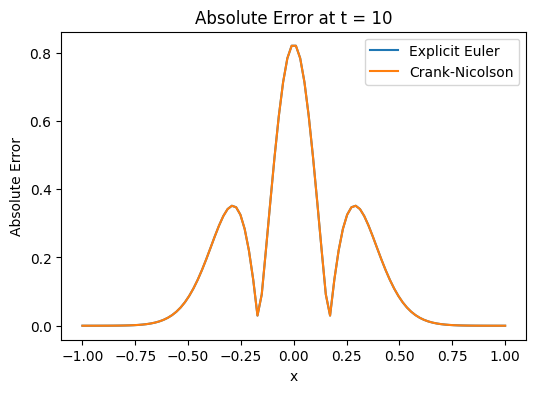

x values where error is least (Explicit Euler): [-0.17171717]
x values where error is least (Crank-Nicolson): [-0.17171717]


In [14]:
# Add code to plot error here
# Absolute error
# Defining parameters
kappa = 0.001  # diffusivity
t_end = 10  # final time
Nx = 100  # number of grid points in x
Nt = 1000  # number of time steps

# Size of the physical domain
x_start = -1
x_end = 1

# Create x and t vectors
x = np.linspace(x_start, x_end, Nx)
t = np.linspace(0, t_end, Nt)

# Run the simulations
c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)

def exact_solution(x, t, kappa):
    return (4 * np.pi * kappa * t)**(-0.5) * np.exp(-x**2 / (4 * kappa * t))

c_exact = exact_solution(x, t_end, kappa)

# Calculate the exact solution at the final time
c_exact = exact_solution(x, t_end, kappa)

# Calculate absolute error at each x for t=10
absolute_error_EE = np.abs(c_EE[:, -1] - c_exact)  # For Explicit Euler
absolute_error_CN = np.abs(c_CN[:, -1] - c_exact)  # For Crank-Nicolson

# Plot the absolute errors
plt.figure(figsize=(6, 4))
plt.plot(x, absolute_error_EE, label='Explicit Euler')
plt.plot(x, absolute_error_CN, label='Crank-Nicolson')
plt.xlabel('x')
plt.ylabel('Absolute Error')
plt.title('Absolute Error at t = 10')
plt.legend()
plt.show()

# Define the range of x values to consider
x_range = x[(x >= -0.25) & (x <= 0.25)]

# Find the indices of the minimum error within the range (for either method)
min_error_indices_EE = np.where(absolute_error_EE[(x >= -0.25) & (x <= 0.25)] == np.min(absolute_error_EE[(x >= -0.25) & (x <= 0.25)]))[0]
min_error_indices_CN = np.where(absolute_error_CN[(x >= -0.25) & (x <= 0.25)] == np.min(absolute_error_CN[(x >= -0.25) & (x <= 0.25)]))[0]


# Get the corresponding x values where the error is least
x_min_error_EE = x_range[min_error_indices_EE]
x_min_error_CN = x_range[min_error_indices_CN]

# Print the x values
print("x values where error is least (Explicit Euler):", x_min_error_EE)
print("x values where error is least (Crank-Nicolson):", x_min_error_CN)



Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.05 seconds


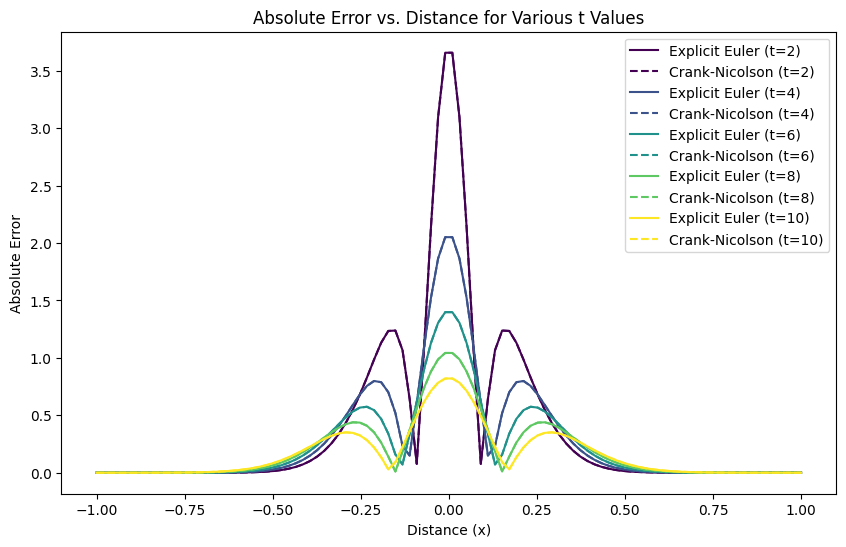

In [15]:
import matplotlib.cm as cm

# ... (Existing code for EE, CN, set_ics, and exact_solution functions) ...

# Defining parameters
kappa = 0.001  # diffusivity
Nx = 100  # number of grid points in x
Nt = 1000  # number of time steps
x_start = -1
x_end = 1

# Create x and t vectors
x = np.linspace(x_start, x_end, Nx)
t = np.linspace(0, 10, Nt)  # t values from 0 to 10

# Run the simulations
c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)

# Times at which to calculate absolute error
t_values = [2, 4, 6, 8, 10]

# Create colormap for different t values
colors = cm.viridis(np.linspace(0, 1, len(t_values)))

# Create plot
plt.figure(figsize=(10, 6))

# Calculate and plot absolute errors for each t value
for i, t_val in enumerate(t_values):
    # Find the closest time index in the t array
    t_index = np.argmin(np.abs(t - t_val))

    # Calculate exact solution at the current time
    c_exact = exact_solution(x, t_val, kappa)

    # Calculate absolute errors for EE and CN
    absolute_error_EE = np.abs(c_EE[:, t_index] - c_exact)
    absolute_error_CN = np.abs(c_CN[:, t_index] - c_exact)

    # Plot the absolute errors with different colors for each t value
    plt.plot(x, absolute_error_EE, label=f'Explicit Euler (t={t_val})', color=colors[i])
    plt.plot(x, absolute_error_CN, label=f'Crank-Nicolson (t={t_val})', color=colors[i], linestyle='--')

plt.xlabel('Distance (x)')
plt.ylabel('Absolute Error')
plt.title('Absolute Error vs. Distance for Various t Values')
plt.legend()
plt.show()

In [16]:
# Defining parameters
kappa = 0.001  # diffusivity
t_end = 10  # final time
Nx = 100  # number of grid points in x
Nt = 1000  # number of time steps

# Size of the physical domain
x_start = -1
x_end = 1

# Create x and t vectors
x = np.linspace(x_start, x_end, Nx)
t = np.linspace(0, t_end, Nt)

# Run the simulations
c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)

# Find the index of the closest x value to 0.17171717
x_target = 0.25
index = np.argmin(np.abs(x - x_target))

# Get the numerical solutions at the target x and final time
numerical_solution_EE = c_EE[index, -1]
numerical_solution_CN = c_CN[index, -1]

# Calculate the analytical solution at the target x and final time
analytical_solution = exact_solution(x_target, t_end, kappa)

# Print the results
print(f"Numerical Solution (Explicit Euler) at x = {x_target:.8f}, t = {t_end}: {numerical_solution_EE:.8f}")
print(f"Numerical Solution (Crank-Nicolson) at x = {x_target:.8f}, t = {t_end}: {numerical_solution_CN:.8f}")
print(f"Analytical Solution at x = {x_target:.8f}, t = {t_end}: {analytical_solution:.8f}")

Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds
Numerical Solution (Explicit Euler) at x = 0.25000000, t = 10: 0.89821611
Numerical Solution (Crank-Nicolson) at x = 0.25000000, t = 10: 0.89810321
Analytical Solution at x = 0.25000000, t = 10: 0.59130281


Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.10 seconds
Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.20 seconds
Explicit Euler method took 0.12 seconds
Crank-Nicolson method took 0.55 seconds
Explicit Euler method took 0.10 seconds


<ipython-input-3-9171c2f9dd57>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


Crank-Nicolson method took 1.90 seconds


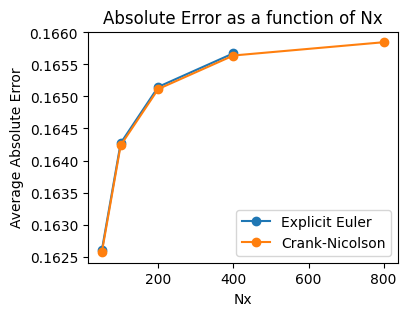

Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.09 seconds


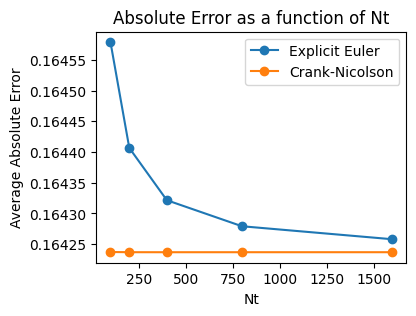

In [17]:
# Defining parameters
kappa = 0.001  # diffusivity
t_end = 10  # final time
x_start = -1
x_end = 1

# --- Error as a function of Nx ---

# Varying Nx values
Nx_values = [50, 100, 200, 400, 800]
Nt = 1000  # Fixed Nt

errors_EE_Nx = []
errors_CN_Nx = []

for Nx in Nx_values:
    # Create x and t vectors for current Nx
    x = np.linspace(x_start, x_end, Nx)
    t = np.linspace(0, t_end, Nt)

    # Run simulations
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)

    # Calculate exact solution
    c_exact = exact_solution(x, t_end, kappa)

    # Calculate absolute error and average over x
    error_EE = np.mean(np.abs(c_EE[:, -1] - c_exact))
    error_CN = np.mean(np.abs(c_CN[:, -1] - c_exact))

    errors_EE_Nx.append(error_EE)
    errors_CN_Nx.append(error_CN)

# Plot error vs. Nx
plt.figure(figsize=(4, 3))
plt.plot(Nx_values, errors_EE_Nx, label='Explicit Euler', marker='o')
plt.plot(Nx_values, errors_CN_Nx, label='Crank-Nicolson', marker='o')
plt.xlabel('Nx')
plt.ylabel('Average Absolute Error')
plt.title('Absolute Error as a function of Nx')
plt.legend()
plt.show()


# --- Error as a function of Nt ---

# Varying Nt values
Nt_values = [100, 200, 400, 800, 1600]
Nx = 100  # Fixed Nx

errors_EE_Nt = []
errors_CN_Nt = []

for Nt in Nt_values:
    # Create x and t vectors for current Nt
    x = np.linspace(x_start, x_end, Nx)
    t = np.linspace(0, t_end, Nt)

    # Run simulations
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)

    # Calculate exact solution
    c_exact = exact_solution(x, t_end, kappa)

    # Calculate absolute error and average over x
    error_EE = np.mean(np.abs(c_EE[:, -1] - c_exact))
    error_CN = np.mean(np.abs(c_CN[:, -1] - c_exact))

    errors_EE_Nt.append(error_EE)
    errors_CN_Nt.append(error_CN)

# Plot error vs. Nt
plt.figure(figsize=(4, 3))
plt.plot(Nt_values, errors_EE_Nt, label='Explicit Euler', marker='o')
plt.plot(Nt_values, errors_CN_Nt, label='Crank-Nicolson', marker='o')
plt.xlabel('Nt')
plt.ylabel('Average Absolute Error')
plt.title('Absolute Error as a function of Nt')
plt.legend()
plt.show()

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

In [18]:

# Defining parameters
kappa = 0.001  # diffusivity
t_end = 10  # final time
x_start = -1
x_end = 1

# Error tolerance
error_tolerance = 1e-4

# --- Find optimal Nx and Nt for each method ---

# Function to find optimal parameters for a given method
def find_optimal_params(method, error_tolerance):
    Nx = 50  # Initial Nx
    Nt = 100  # Initial Nt

    while True:
        x = np.linspace(x_start, x_end, Nx)
        t = np.linspace(0, t_end, Nt)

        # Run simulation
        start_time = time.time()
        c_num = method(x, t, kappa)
        end_time = time.time()

        # Calculate error
        c_exact = exact_solution(x, t_end, kappa)
        error = np.mean(np.abs(c_num[:, -1] - c_exact))

        # Check if error is within tolerance
        if error < error_tolerance:
            return Nx, Nt, end_time - start_time

        # Adjust parameters
        if Nx < 500:  # Limit maximum Nx to prevent excessive computation
            Nx *= 2
        else:
            Nt *= 2


# Find optimal parameters for Explicit Euler and Crank-Nicolson
Nx_EE, Nt_EE, time_EE = find_optimal_params(EE, error_tolerance)
Nx_CN, Nt_CN, time_CN = find_optimal_params(CN, error_tolerance)

# --- Print and plot results ---

print(f"Explicit Euler: Nx = {Nx_EE}, Nt = {Nt_EE}, Time = {time_EE:.4f} seconds")
print(f"Crank-Nicolson: Nx = {Nx_CN}, Nt = {Nt_CN}, Time = {time_CN:.4f} seconds")

# Create bar plot for comparison
methods = ['Explicit Euler', 'Crank-Nicolson']
times = [time_EE, time_CN]

plt.figure(figsize=(6, 4))
plt.bar(methods, times, color=['blue', 'orange'])
plt.ylabel('Time (seconds)')
plt.title('Computational Time Comparison')
plt.show()

ModuleNotFoundError: No module named 'Project1_numerical_methods'

Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?